# Convolutional ViT

- paper : https://arxiv.org/pdf/2103.15808
- official code : https://github.com/microsoft/CvT






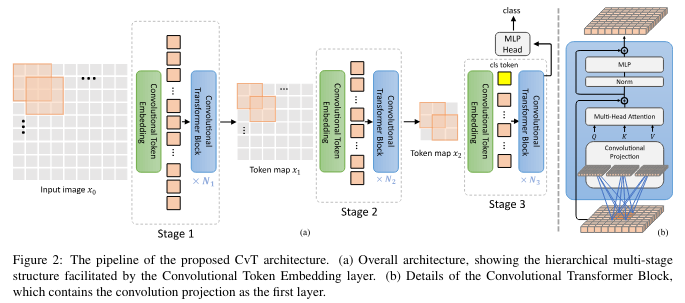

- Vision Transformer tutorial :https://github.com/seonm9119/tutorials/blob/main/Vision%20Transformer.ipynb
- Swin Transformer tutorial : https://github.com/seonm9119/tutorials/blob/main/Swin.ipynb

여담이지만, Swin Transformer와 CvT (Convolutional Vision Transformer)는 모두 2021년 ICCV에 발표된 논문이다. Swin이 많은 인기를 얻은 반면, CvT는 상대적으로 덜 알려져 있지만, 개인적으로 ViT에 Convolution을 도입한 아이디어는 꽤 흥미롭다고 생각한다. 논문의 실험 결과를 바탕으로 성능을 비교해 보면, 성능 측면에서는 Swin이 더 우세하다. 하지만, 해당 논문에서 흥미롭게 본 부분은 연산량에 있다.

아래의 표는 $224^2$사이즈로 학습한 결과표이다. 수치는 각각의 논문에서 발췌했다. 모델 경량화를 위한 모델로서 의미가 있다라고 생각된다. 물론 이러한 목적으로 제안된 논문은 아니다!

Method | # param. | FLOPs | ImagNet-1K
:---: | :---: | :---: |  :---:
CvT-13  | 20M | 4.5G  | 81.6
Swin-T  | 29M | 4.5G  | 81.3
CvT-21  | 32M | 7.1G  | 82.5
Swin-S  | 50M | 8.7G  | 83.0
Swin-B | 88M | 15.4G | 83.5

Vision Transformer가 발표된 이후, 계층적 구조로 모델을 설계하는 아이디어를 가진 논문들이 많이 발표되었다. 이번 논문은 컨볼루션을 활용하여 모델을 계층적으로 설계하는 방법을 제시한다. CvT의 주요 아이디어는 Vision Transformer에 Convolution을 도입하여 CNN의 이점을 ViT에 통합한다. 구체적인 방법은 다음과 같다.

- 첫째, ViT를 여러 계층으로 분리한다. Swin과 마찬가지로 계층적 구조를 설계하기 위해 multiple stages로 구성하며, 각 계층의 token embedding을 Convolution token embedding으로 대체한다.
- 둘째, Self-attention block의 linear projection을 Convolution으로 변경한다.

그럼 자세히 알아보자!

# Let's GO!

### Setup Codes

In [ ]:
%load_ext autoreload
%autoreload 2

#### Google Colab Setup
we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section. Run the following cell to mount your Google Drive.

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'GIT/tutorials/utils/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

#### Import packages

In [ ]:
!pip install einops

In [ ]:
import torch
import torch.nn as nn

### Load Datasets

we will be working on the CIFAR-100, CIFAR-10 dataset, which has 60,000 training and 10,000 test images. we will use the PyTorch CIFAR-100, CIFAR-10 wrapper. See the [documentation](https://github.com/pytorch/vision/blob/main/torchvision/datasets/cifar.py) for more information about the interface.

In [ ]:
from torch.utils.data import DataLoader

# custom packages
from data.cifar import CIFAR100, CIFAR10

In [ ]:
# for pre-train
train_dataset = CIFAR100(root='.', train=True, image_size=32)
test_dataset = CIFAR100(root='.', train=False, image_size=32)

pre_train = {}
pre_train['train'] = DataLoader(train_dataset, batch_size=128, shuffle=True)
pre_train['test'] = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# for fine-tune
train_dataset = CIFAR10(root='.', train=True, image_size=32)
test_dataset = CIFAR10(root='.', train=False, image_size=32)

fine_tune = {}
fine_tune['train'] = DataLoader(train_dataset, batch_size=128, shuffle=True)
fine_tune['test'] = DataLoader(test_dataset, batch_size=128, shuffle=False)

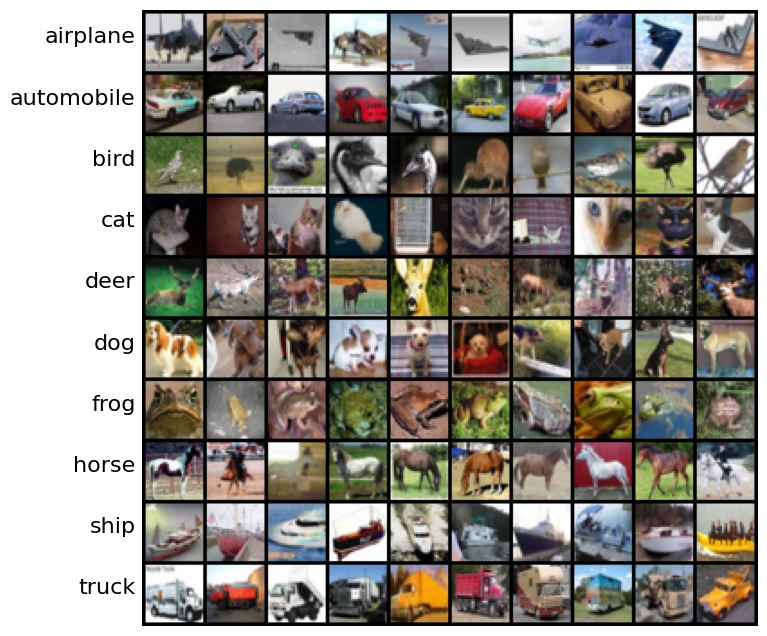

In [ ]:
train_dataset.visualize_dataset(samples_per_class=10)

## Build a Convolutional ViT

In [ ]:
from einops import rearrange
from einops.layers.torch import Rearrange
import torch.nn.functional as F

# custom packages
from models.vit.sublayers import Mlp

In [ ]:
class ConvolutionVisionTransformer(nn.Module):
  def __init__(self,
               img_size=224,
               in_chans=3,
               patch_size=[7, 3, 3],
               patch_stride=[4, 2, 2],
               patch_padding=[2, 1, 1],
               embed_dim=[64, 192, 384],
               depths=[1, 2, 10],
               num_heads=[1, 3, 6],
               num_classes=1000,
               mlp_ratio=4.,
               dropout=0.1):
      super().__init__()

      n_stages = len(depths)
      in_chans = [in_chans] + embed_dim
      self.norm = nn.LayerNorm(embed_dim[-1])

      self.stages = nn.ModuleList([
          VisionTransformer4CvT(in_chans=in_chans[_idx],
                                patch_size=patch_size[_idx],
                                patch_stride=patch_stride[_idx],
                                patch_padding=patch_padding[_idx],
                                embed_dim=embed_dim[_idx],
                                depths=depths[_idx],
                                num_heads=num_heads[_idx],
                                mlp_ratio=4.,
                                dropout=0.1,
                                cls_token=True if _idx < (n_stages - 1) else False) for _idx in range(n_stages)])


      self.mlp_head = nn.Linear(embed_dim[-1], num_classes)

  def forward(self, x):


    for _stage in self.stages:
      x, cls_tokens = _stage(x)

    x = rearrange(x, 'b c h w -> b (h w) c')
    x = self.norm(x)
    x = torch.mean(x, dim=1)

    return self.mlp_head(x)

In [ ]:
class VisionTransformer4CvT(nn.Module):
    def __init__(self,in_chans=3,
                 patch_size=16,
                 patch_stride=16,
                 patch_padding=0,
                 embed_dim=768,
                 depths=12,
                 num_heads=12,
                 mlp_ratio=4.,
                 dropout=0.1,
                 cls_token=True):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.pos_drop = nn.Dropout(dropout)


        self.conv_embed = nn.Conv2d(in_chans, embed_dim,
                                     kernel_size=patch_size, stride=patch_stride, padding=patch_padding)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if cls_token else None

        self.blocks = nn.ModuleList([
            Block4CvT(dim=embed_dim,
                      num_heads=num_heads,
                      mlp_ratio=mlp_ratio,
                      dropout=dropout,
                      cls_token=cls_token) for _ in range(depths)])


    def forward(self, x):

        x = self.conv_embed(x)

        B, C, H, W = x.size()

        x = rearrange(x, 'b c h w -> b (h w) c')

        cls_tokens = None
        if self.cls_token is not None:
            cls_tokens = self.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)

        x = self.pos_drop(x)

        for blk in self.blocks:
          x = blk(x, H, W)


        if self.cls_token is not None:
            cls_tokens, x = torch.split(x, [1, H*W], 1)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H, w=W)

        return x, cls_tokens

저자는 Convolutional Patch Embedding을 도입하여, Convolution 연산을 통해 자연스럽게 계층적 모델을 구현한다. CNN을 연상하면 이해가 쉽다. 그럼, 왜 Convolution을 적용하면 이점이 있는지 대해 생각해보자.

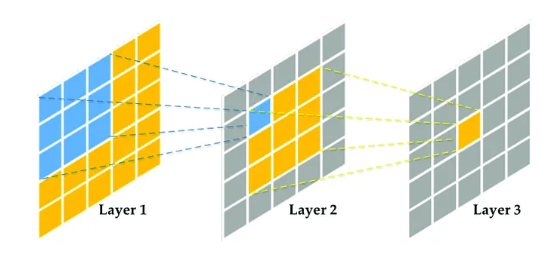

위 그림은 receptive field를 나타낸다. Convolution 연산을 수행할 경우, 층이 깊어질수록 하나의 영역이 그 이전의 더 많은 영역을 포함하게 된다. 즉, 마지막 층에서는 더 많은 주변 정보를 담게 된다.

기존의 Patch Embedding을 생각해보면, 하나의 패치는 한 영역만을 담고 있다. 그러나 이미지에는 여러 Scale이 존재하기 때문에 고정된 크기로는 다양한 Scale을 포착하지 못하는 문제가 있다. 이러한 문제를 해결하기 위해 Convolution을 사용한다고 볼 수 있다.

하지만, 기존의 Patch Embedding에 Convolution을 적용하면 새로운 문제가 발생한다. 기존의 Multi-Head Self-Attention (MSA)은 sequential한 토큰 임베딩을 다루지만, Convolution을 적용한 토큰 임베딩은 2D 형태가 된다. 이러한 문제를 해결하기 위해 저자는 기존의 linear projection을 Convolution으로 대체한다.

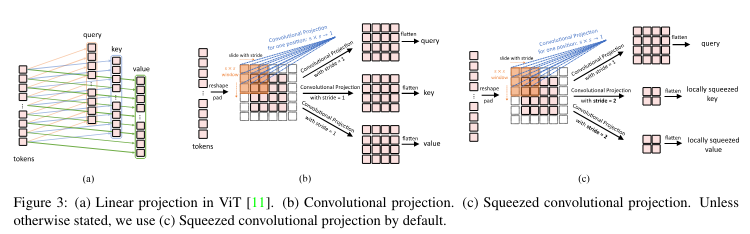

위 그림은 ViT와 CvT의 projection 방식을 나타낸다. ViT의 경우, 하나의 토큰은 하나의 고정된 영역만을 포함하고 이후에 attention을 수행한다. 반면, CvT는 토큰 맵에 Convolution 연산을 적용하여 하나의 토큰이 주변 영역의 정보도 담을 수 있도록 구성되었다.

In [ ]:
class Attention4CvT(nn.Module):
    def __init__(self, dim,
                 num_heads,
                 kernel_size=3,
                 stride_kv=1,
                 stride_q=1,
                 padding_kv=1,
                 padding_q=1,
                 cls_token=True,
                 dropout=0.1
                 ):
        super().__init__()


        self.cls_token = cls_token
        self.num_heads = num_heads

        self.conv_proj_q = nn.Sequential(*[
            nn.Conv2d(dim, dim, kernel_size, stride_q, padding_q, bias=False, groups=dim),
            nn.BatchNorm2d(dim),
            Rearrange('b c h w -> b (h w) c')])

        self.conv_proj_k = nn.Sequential(*[
            nn.Conv2d(dim, dim, kernel_size, stride_kv, padding_kv, bias=False, groups=dim),
            nn.BatchNorm2d(dim),
            Rearrange('b c h w -> b (h w) c')])

        self.conv_proj_v = nn.Sequential(*[
            nn.Conv2d(dim, dim, kernel_size, stride_kv, padding_kv, bias=False, groups=dim),
            nn.BatchNorm2d(dim),
            Rearrange('b c h w -> b (h w) c')])


        self.proj_q = nn.Linear(dim, dim, bias=True)
        self.proj_k = nn.Linear(dim, dim, bias=True)
        self.proj_v = nn.Linear(dim, dim, bias=True)

        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)



    def forward_conv(self, x, h, w):

        if self.cls_token:
            cls_token, x = torch.split(x, [1, h*w], 1)

        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        q = self.conv_proj_q(x)
        k = self.conv_proj_k(x)
        v = self.conv_proj_v(x)

        if self.cls_token:
            q = torch.cat((cls_token, q), dim=1)
            k = torch.cat((cls_token, k), dim=1)
            v = torch.cat((cls_token, v), dim=1)

        return q, k, v

    def forward(self, x, h, w):

        q, k, v = self.forward_conv(x, h, w)


        q = rearrange(self.proj_q(q), 'b t (h d) -> b h t d', h=self.num_heads)
        k = rearrange(self.proj_k(k), 'b t (h d) -> b h t d', h=self.num_heads)
        v = rearrange(self.proj_v(v), 'b t (h d) -> b h t d', h=self.num_heads)

        attn_score = torch.einsum('bhlk,bhtk->bhlt', [q, k]) * 0.5
        attn = F.softmax(attn_score, dim=-1)
        attn = self.attn_drop(attn)

        x = torch.einsum('bhlt,bhtv->bhlv', [attn, v])
        x = rearrange(x, 'b h t d -> b t (h d)')

        x = self.proj(x)
        x = self.proj_drop(x)

        return x



In [ ]:
class Block4CvT(nn.Module):

    def __init__(self, dim,
                 num_heads,
                 mlp_ratio=4.,
                 dropout=0.1,
                 cls_token=True):
        super().__init__()

        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

        self.attn = Attention4CvT(dim=dim,
                                  num_heads=num_heads,
                                  cls_token=cls_token,
                                  dropout=dropout)


        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim,
                       hidden_features=mlp_hidden_dim,
                       drop=dropout)

    def forward(self, x, h, w):
        attn = self.attn(self.norm1(x), h, w)
        res = x + self.dropout(attn)

        ffd = self.mlp(self.norm2(res))
        out = res + self.dropout(ffd)

        return out

## Train a Net

위에서 구현한 모델은 논문의 핵심 개념을 이해하기 쉽도록 간단히 구현한 것이다. 스케줄러, 초기 가중치 설정 등의 세부 사항은 논문과 공식 코드를 참고하여 모델을 더 구체화하길 권장한다. 그럼 구현한 모델을 학습시켜 보자!

In [ ]:
# custom packages
from colab_utils.vit import runner

일반적으로 사전 학습 단계에서는 대규모 데이터셋인 ImageNet을 사용한다. 하지만 우리는 간단한 테스트를 해보기위해 CIFAR-100을 사용하여 모델을 사전 학습시킨다.

In [ ]:
pre_model = ConvolutionVisionTransformer(img_size=32,
               in_chans=3,
               patch_size=[7, 3, 3],
               patch_stride=[4, 2, 2],
               patch_padding=[2, 1, 1],
               embed_dim=[64, 192, 384],
               depths=[1, 2, 10],
               num_heads=[1, 3, 6],
               num_classes=100,
               mlp_ratio=4.,
               dropout=0.1)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pre_model.parameters(), lr=1e-3)

In [ ]:
history = runner(pre_model, criterion, optimizer, pre_train, num_epochs=10, msg=2)
torch.save(pre_model.state_dict(), 'pre_train.pth')

Train using cuda
Epoch [2/10]          time: 0:01:29          train Loss: 3.2292          train ACC: 21.37%          val Loss: 3.1312          val ACC: 23.64%
Epoch [4/10]          time: 0:01:31          train Loss: 2.8084          train ACC: 29.43%          val Loss: 2.8475          val ACC: 29.76%
Epoch [6/10]          time: 0:01:32          train Loss: 2.6196          train ACC: 33.15%          val Loss: 2.7433          val ACC: 31.21%
Epoch [8/10]          time: 0:01:30          train Loss: 2.5232          train ACC: 35.29%          val Loss: 2.7425          val ACC: 31.93%
Epoch [10/10]          time: 0:01:30          train Loss: 2.4426          train ACC: 37.01%          val Loss: 2.7616          val ACC: 31.26%

Finished Training
Toral Training Time: 0:07:33
Accuracy of the test images: 31.40%


학습된 모델을 활용하여 다운스트림 태스크로 CIFAR-10의 Classification을 수행해보자!

In [ ]:
fine_model = ConvolutionVisionTransformer(img_size=32,
               in_chans=3,
               patch_size=[7, 3, 3],
               patch_stride=[4, 2, 2],
               patch_padding=[2, 1, 1],
               embed_dim=[64, 192, 384],
               depths=[1, 2, 10],
               num_heads=[1, 3, 6],
               num_classes=100,
               mlp_ratio=4.,
               dropout=0.1)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_model.parameters(), lr=1e-3)

In [ ]:
checkpoint = torch.load("pre_train.pth")
checkpoint = {key: val for key, val in checkpoint.items() if 'head' not in key}
fine_model.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=['mlp_head.weight', 'mlp_head.bias'], unexpected_keys=[])

In [ ]:
history = runner(fine_model, criterion, optimizer, fine_tune, num_epochs=5, msg=1)
torch.save(fine_model.state_dict(), 'fine_tune.pth')

Train using cuda
Epoch [1/5]          time: 0:00:45          train Loss: 1.3394          train ACC: 52.40%          val Loss: 1.1901          val ACC: 56.95%
Epoch [2/5]          time: 0:00:44          train Loss: 1.1455          train ACC: 58.82%          val Loss: 1.1465          val ACC: 59.01%
Epoch [3/5]          time: 0:00:46          train Loss: 1.1078          train ACC: 60.12%          val Loss: 1.1454          val ACC: 58.95%
Epoch [4/5]          time: 0:00:44          train Loss: 1.0903          train ACC: 60.98%          val Loss: 1.1281          val ACC: 60.42%
Epoch [5/5]          time: 0:00:46          train Loss: 1.0730          train ACC: 61.63%          val Loss: 1.1019          val ACC: 60.21%

Finished Training
Toral Training Time: 0:03:45
Accuracy of the test images: 60.04%
